In [129]:
import sys
import re
import logging
from datetime import datetime, timedelta

import pandas as pd

from kite_login import KiteLogin
from instruments_token import InstrumentToken
from ai_data_generator import AiDataGenerator

import matplotlib.pyplot as plt

from settings import Setting

logging.basicConfig(stream=sys.stdout, level=logging.INFO,
	format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")

In [130]:
setting = Setting()
kite_login = KiteLogin(setting, logging)
kite_login.connect()

2025-05-30 11:09:58,550 - root - INFO - User Profile: == * Gayatri Sharan Rajwade * ==
2025-05-30 11:09:58,551 - root - INFO - Connected to kite successfully: <kiteconnect.connect.KiteConnect object at 0x16ca23bb0>


In [131]:
instrument_token = InstrumentToken(setting, logging)
instrument_token.load_instrument_tokens(kite_login)
instrument_items = {}
for item in instrument_token.instrument_tokens:
    if re.match(r"^NIFTY25", item["tradingsymbol"]):
        instrument_items[item['instrument_token']] = item['tradingsymbol']

In [132]:
instrument_items

{14536962: 'NIFTY25JUNFUT',
 13623298: 'NIFTY25JULFUT',
 16410370: 'NIFTY25AUGFUT',
 10364162: 'NIFTY2560524850CE',
 10364418: 'NIFTY2560524850PE',
 10363138: 'NIFTY2560524800CE',
 10363394: 'NIFTY2560524800PE',
 10364674: 'NIFTY2560524900CE',
 10364930: 'NIFTY2560524900PE',
 10362114: 'NIFTY2560524750CE',
 10362626: 'NIFTY2560524750PE',
 10365186: 'NIFTY2560524950CE',
 10365442: 'NIFTY2560524950PE',
 10361602: 'NIFTY2560524700CE',
 10361858: 'NIFTY2560524700PE',
 10365698: 'NIFTY2560525000CE',
 10365954: 'NIFTY2560525000PE',
 10361090: 'NIFTY2560524650CE',
 10361346: 'NIFTY2560524650PE',
 10366210: 'NIFTY2560525050CE',
 10366466: 'NIFTY2560525050PE',
 10360578: 'NIFTY2560524600CE',
 10360834: 'NIFTY2560524600PE',
 10366722: 'NIFTY2560525100CE',
 10366978: 'NIFTY2560525100PE',
 10360066: 'NIFTY2560524550CE',
 10360322: 'NIFTY2560524550PE',
 10367746: 'NIFTY2560525150CE',
 10368002: 'NIFTY2560525150PE',
 10359554: 'NIFTY2560524500CE',
 10359810: 'NIFTY2560524500PE',
 10368770: 'NIFTY256

In [108]:
ai_data_generator = AiDataGenerator(setting, logging)
current_time = datetime.now() - timedelta(days=0)
current_time

datetime.datetime(2025, 5, 27, 21, 0, 4, 997348)

In [109]:
data = ai_data_generator.fetch_ticks(current_time)


                SELECT id, token, date, last_price, oi, volume_traded 
                FROM tick_details_copy
                WHERE date >= '2025-05-27 09:15:00' AND date <= '2025-05-27 15:30:00'
                ORDER BY id
            


In [110]:
data.tail()

,id,token,date,last_price,oi,volume_traded
379560,951805,15790082,2025-05-27 15:29:41,34.15,6275475,76332675
379561,951806,15792130,2025-05-27 15:29:41,76.00,5095725,95302725
379562,951807,15810562,2025-05-27 15:29:41,331.00,1737150,15441825
379563,951808,15810306,2025-05-27 15:29:41,91.00,6329850,104712150
379564,951809,15814146,2025-05-27 15:29:41,565.80,126900,691575


In [111]:
def encode_direction(row):
    return instrument_items[row['token']]

In [112]:
data["symbol"] = data.apply(encode_direction, axis=1)

In [113]:

grouped = data[["date", "token", "symbol", "oi", "volume_traded"]].groupby("token")

# List to hold filtered groups
filtered_data = []

for token, group in grouped:
    # Filter rows where 'oi' changes
    filtered_group = group[group["oi"].diff() != 0].reset_index(drop=True)
    
    # Optional: Add token column explicitly (in case it's the index after grouping)
    filtered_group["token"] = token

    if not filtered_group.empty:
        filtered_data.append(filtered_group)

# Combine all into one DataFrame
combined_df = pd.concat(filtered_data, ignore_index=True)

print(combined_df[["token", "symbol"]].drop_duplicates())

# Save to a single CSV
combined_df.to_csv("filtered_oi_changes.csv", index=False)

         token             symbol
0     14626050      NIFTY25MAYFUT
104   15789826  NIFTY25MAY24400CE
203   15790082  NIFTY25MAY24400PE
306   15790850  NIFTY25MAY24500CE
409   15791106  NIFTY25MAY24500PE
512   15791874  NIFTY25MAY24600CE
615   15792130  NIFTY25MAY24600PE
718   15792898  NIFTY25MAY24700CE
821   15793154  NIFTY25MAY24700PE
923   15801602  NIFTY25MAY24800CE
1026  15801858  NIFTY25MAY24800PE
1129  15808258  NIFTY25MAY24900CE
1232  15808514  NIFTY25MAY24900PE
1335  15809282  NIFTY25MAY25000CE
1438  15809538  NIFTY25MAY25000PE
1541  15810306  NIFTY25MAY25100CE
1644  15810562  NIFTY25MAY25100PE
1746  15811330  NIFTY25MAY25200CE
1829  15811586  NIFTY25MAY25200PE
1911  15812354  NIFTY25MAY25300CE
1987  15812610  NIFTY25MAY25300PE
2062  15813378  NIFTY25MAY25400CE
2136  15814146  NIFTY25MAY25400PE


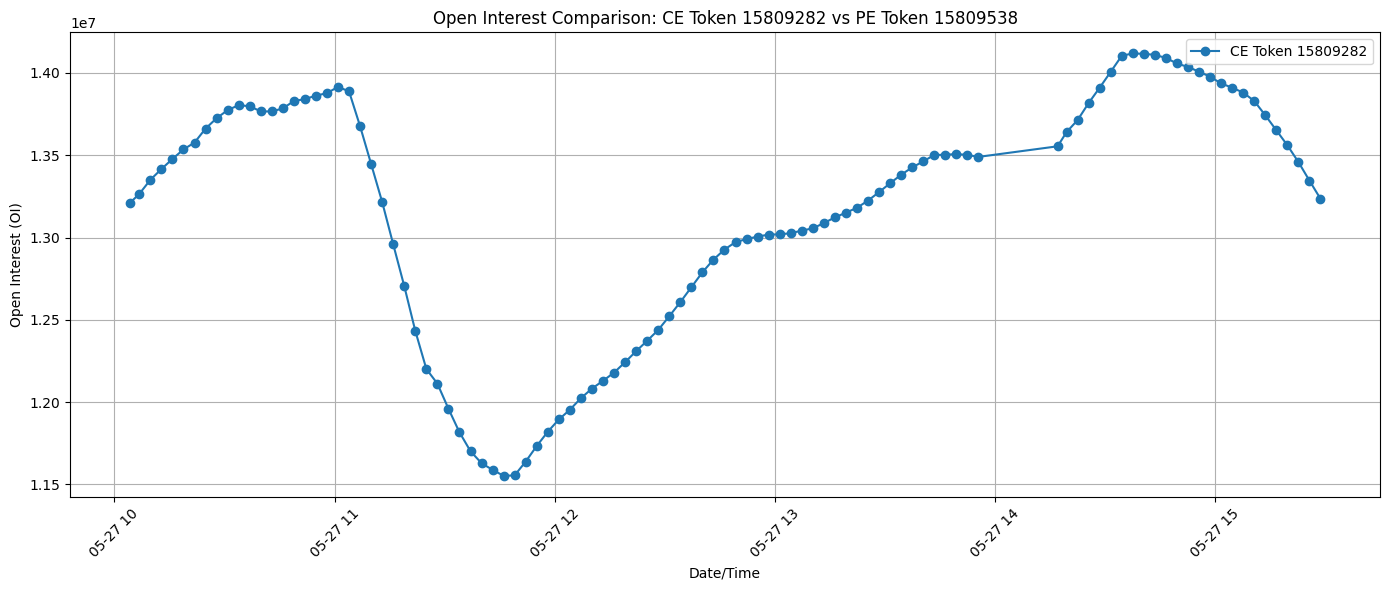

In [128]:
import matplotlib.pyplot as plt
ce_token = 15809282
pe_token = 15809538

token = pe_token

ce_df = combined_df[combined_df["token"] == ce_token].sort_values(by="date")
ce_df['oi_sma'] = ce_df['oi'].rolling(window=7, min_periods=1).mean()
ce_df['oi_sma_pct'] = ce_df['oi_sma'].pct_change() * 100

pe_df = combined_df[combined_df["token"] == pe_token].sort_values(by="date")
pe_df['oi_sma'] = pe_df['oi'].rolling(window=7, min_periods=1).mean()
pe_df['oi_sma_pct'] = pe_df['oi_sma'].pct_change() * 100

# Plot
plt.figure(figsize=(14, 6))

# plt.plot(ce_df["date"], ce_df["oi_sma_pct"], label=f"CE Token {ce_token}", marker='o')
plt.plot(ce_df["date"], ce_df["oi_sma"], label=f"CE Token {ce_token}", marker='o')
# plt.plot(pe_df["date"], pe_df["oi_sma"], label=f"PE Token {pe_token}", marker='x')

plt.title(f"Open Interest Comparison: CE Token {ce_token} vs PE Token {pe_token}")
plt.xlabel("Date/Time")
plt.ylabel("Open Interest (OI)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

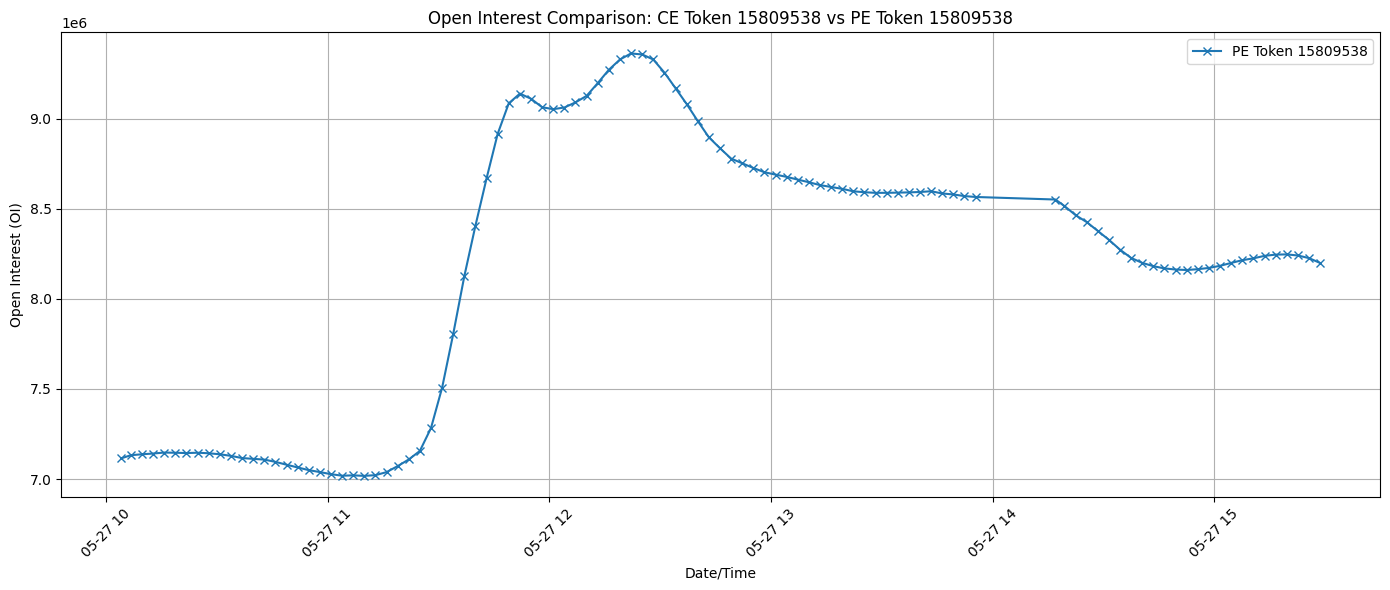

In [127]:
# Plot
plt.figure(figsize=(14, 6))

plt.plot(pe_df["date"], pe_df["oi_sma"], label=f"PE Token {pe_token}", marker='x')
# plt.plot(pe_df["date"], pe_df["oi_sma_pct"], label=f"PE Token {pe_token}", marker='o')

plt.title(f"Open Interest Comparison: CE Token {pe_token} vs PE Token {pe_token}")
plt.xlabel("Date/Time")
plt.ylabel("Open Interest (OI)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [74]:
df['sma_pct'] = df['oi_sma'].pct_change() * 100

In [75]:
df.to_csv("filtered_sma_pct.csv", index=False)

In [69]:
f"{2.200897:.2f}".rstrip('.')

'2.20'

In [68]:
data_df = pd.read_csv('traning_data.csv')
data_df

,unique_key,date,trend,direction,signal,last_price,candle,nearest_strike,nearest_pe_oi,nearest_ce_oi,...,next_ce_oi,next_pcr,next_gap,date_id,strike_id,time,nearest_pe_oi_diff,nearest_ce_oi_diff,next_pe_oi_diff,next_ce_oi_diff
0,202505060955,2025-05-06 09:58:28.714891,NaN,Down,NaN,24399.50,NaN,24300,9123900,3328800,...,9165300,1.4860,0.50,20250506,24300-24400,06/05/2025 09:58:28,NaN,NaN,NaN,NaN
1,202505060955,2025-05-06 09:59:08.678491,NaN,Down,NaN,24394.30,NaN,24300,9123900,3328800,...,9165300,1.4860,5.70,20250506,24300-24400,06/05/2025 09:59:08,0.0,0.0,0.0,0.0
2,202505060955,2025-05-06 09:59:14.605627,NaN,Down,NaN,24394.25,NaN,24300,9123900,3328800,...,9165300,1.4860,5.75,20250506,24300-24400,06/05/2025 09:59:14,0.0,0.0,0.0,0.0
3,202505060955,2025-05-06 09:59:20.307706,NaN,Down,NaN,24392.15,NaN,24300,9123900,3328800,...,9165300,1.4860,7.85,20250506,24300-24400,06/05/2025 09:59:20,0.0,0.0,0.0,0.0
4,202505060955,2025-05-06 09:59:25.980849,NaN,Down,NaN,24391.80,NaN,24300,9123900,3328800,...,9165300,1.4860,8.20,20250506,24300-24400,06/05/2025 09:59:25,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18825,202505131130,2025-05-13 11:31:41.663907,NaN,Up,NaN,24803.75,NaN,24800,4700775,6909600,...,4778775,0.4126,96.25,20250513,24800-24900,13/05/2025 11:31:41,0.0,0.0,0.0,0.0
18826,202505131130,2025-05-13 11:31:48.489594,NaN,Up,NaN,24807.55,NaN,24800,4700775,6909600,...,4778775,0.4126,92.45,20250513,24800-24900,13/05/2025 11:31:48,0.0,0.0,0.0,0.0
18827,202505131130,2025-05-13 11:31:55.219278,NaN,Up,NaN,24800.65,NaN,24800,4700775,6909600,...,4778775,0.4126,99.35,20250513,24800-24900,13/05/2025 11:31:55,0.0,0.0,0.0,0.0
18828,202505131130,2025-05-13 11:34:40.610127,NaN,Up,NaN,24813.15,NaN,24800,4719525,6786675,...,4746900,0.4180,86.85,20250513,24800-24900,13/05/2025 11:34:40,18750.0,-122925.0,12750.0,-31875.0


In [7]:
columns = ['date_id', 'strike_id', 'time', 'nearest_pe_oi', 'nearest_pe_oi_diff', 'nearest_ce_oi', 'nearest_ce_oi_diff', 'nearest_pcr', 
           'next_pe_oi', 'next_pe_oi_diff', 'next_ce_oi', 'next_ce_oi_diff', 'next_pcr']
data_df.sort_values(by='time')[columns].to_csv('traning_data1.csv', index=False)

In [46]:
data_df = data_df[data_df['old_ce_oi'] != 0.0]
data_df = data_df[data_df['old_pe_oi'] != 0.0]

In [36]:
data_df["ce_change"] = round((data_df["ce_curr_oi"] - data_df["old_ce_oi"])*100/data_df["old_ce_oi"], 2)
data_df["pe_change"] = round((data_df["pe_curr_oi"] - data_df["old_pe_oi"])*100/data_df["old_pe_oi"], 2)
data_df["ce_pe_change"] = round(data_df["ce_pe_oi_ratio"].pct_change() * 100, 2)
traning_df = data_df

In [37]:
traning_df['action_new'] = None
traning_df['oi_diff'] = 0.0

# Loop through the DataFrame
hold_buy_mode = False
hold_sell_mode = False
pre_oi = 1
for i in range(len(traning_df)):
    row = traning_df.iloc[i]

    if not (hold_buy_mode or hold_sell_mode): 
        if row['ce_pe_change'] and row['ce_pe_change'] > 200 and row["ce_change"] > 100:
            traning_df.at[i, 'action_new'] = 'Buy'
            pre_oi = row['old_ce_oi']
            traning_df.at[i, 'oi_diff'] = row["ce_change"]
            hold_buy_mode = True
           
        elif row['ce_pe_change'] and row['ce_pe_change'] < -60 and row["pe_change"] > 100:
            traning_df.at[i, 'action_new'] = 'Sell'
            pre_oi = row['old_pe_oi']
            traning_df.at[i, 'oi_diff'] = row["pe_change"]
            hold_sell_mode = True
        else:
            traning_df.at[i, 'action_new'] = 'No Trade'
            pre_oi = 1
    else:
        if hold_buy_mode and (row["ce_curr_oi"] - pre_oi)*100/pre_oi < 60:
            traning_df.at[i, 'action_new'] = 'No Trade'
            pre_oi = 1
            hold_buy_mode = False
        elif hold_sell_mode and (row["pe_curr_oi"] - pre_oi)*100/pre_oi < 60:
            traning_df.at[i, 'action_new'] = 'No Trade'
            pre_oi = 1
            hold_sell_mode = False
        elif hold_buy_mode:
            vol = (row["ce_curr_oi"] - pre_oi)*100/pre_oi
            traning_df.at[i, 'oi_diff'] = round(vol, 2)
            traning_df.at[i, 'action_new'] = 'Buy Hold'
        elif hold_sell_mode:
            vol = (row["pe_curr_oi"] - pre_oi)*100/pre_oi
            traning_df.at[i, 'oi_diff'] = round(vol, 2)
            traning_df.at[i, 'action_new'] = 'Sell Hold'

In [38]:
traning_df = traning_df[traning_df['ce_pe_change'] != 0.0]

In [39]:
traning_df[['date', 'ce_pe_oi_ratio', 'prev_ce_pe_oi_ratio', 'ce_oi_change', 'pe_oi_change', 'ce_change', 'pe_change', 'ce_pe_change', 'action_new','oi_diff']].to_csv('traning_data11.csv', index=False)

In [40]:
data_df

,unique_key,date,direction,ce_beta,ce_oi,old_ce_oi,pe_beta,pe_oi,old_pe_oi,ce_curr_oi,...,pre_ce_oi_change,pe_oi_change,pre_pe_oi_change,state,action,ce_change,pe_change,ce_pe_change,action_new,oi_diff
0,202504300920,2025-04-30 09:20:00,Down,125.6147,0,16255650,-47.0764,0,5560350,16255650,...,1.0000,0.0,1.0000,No Trade,No Trade,0.00,0.00,NaN,No Trade,0.0
1,202504300920,2025-04-30 09:20:00,Down,125.6147,0,16255650,-47.0764,0,5560350,16255650,...,1.0000,0.0,1.0000,No Trade,No Trade,0.00,0.00,0.0,No Trade,0.0
2,202504300920,2025-04-30 09:20:00,Down,125.6147,0,16255650,-47.0764,0,5560350,16255650,...,1.0000,0.0,1.0000,No Trade,No Trade,0.00,0.00,0.0,No Trade,0.0
3,202504300920,2025-04-30 09:20:00,Down,125.6147,0,16255650,-47.0764,0,5560350,16255650,...,1.0000,0.0,1.0000,No Trade,No Trade,0.00,0.00,0.0,No Trade,0.0
4,202504300920,2025-04-30 09:20:00,Down,125.6147,0,16255650,-47.0764,0,5560350,16255650,...,1.0000,0.0,1.0000,No Trade,No Trade,0.00,0.00,0.0,No Trade,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,202504301520,2025-04-30 15:20:00,Down,8.3065,0,2227950,271.6031,0,22534800,2186250,...,0.9813,0.0,1.0282,No Trade,No Trade,-1.87,2.82,0.0,No Trade,0.0
3614,202504301520,2025-04-30 15:20:00,Down,8.3065,0,2227950,271.6031,0,22534800,2186250,...,0.9813,0.0,1.0282,No Trade,No Trade,-1.87,2.82,0.0,No Trade,0.0
3615,202504301520,2025-04-30 15:20:00,Down,8.3065,0,2227950,271.6031,0,22534800,2186250,...,0.9813,0.0,1.0282,No Trade,No Trade,-1.87,2.82,0.0,No Trade,0.0
3616,202504301520,2025-04-30 15:20:00,Down,8.3065,0,2227950,271.6031,0,22534800,2186250,...,0.9813,0.0,1.0282,No Trade,No Trade,-1.87,2.82,0.0,No Trade,0.0


In [48]:
data_df["ce_pe_change"] = round(data_df["ce_pe_oi_ratio"].pct_change() * 100, 2)

In [49]:
for i in range(1, len(data_df)):
    if data_df.loc[i, 'pe_oi_change'] == 1 and data_df.loc[i-1, 'pe_oi_change'] not in [0, 1]:
        data_df.loc[i, 'pe_oi_change'] = data_df.loc[i-1, 'pe_oi_change']
    if data_df.loc[i, 'ce_oi_change'] == 1 and data_df.loc[i-1, 'ce_oi_change'] not in [0, 1]:
        data_df.loc[i, 'ce_oi_change'] = data_df.loc[i-1, 'ce_oi_change']

In [50]:
data_df.to_csv('traning_data1.csv', index=False)

In [51]:
df = data_df[data_df['ce_pe_change'] != 0.0]
df = df[['date', "ce_pe_change"]]
df.to_csv('traning_data4.csv', index=False)

In [52]:
columns_order = [
            'unique_key', 'date', 'time', 'direction', 'ce_pe_oi_ratio', 'prev_ce_pe_oi_ratio',
            'ce_beta', 'ce_oi_change', 'pre_ce_oi_change',
            'pe_beta', 'pe_oi_change', 'pre_pe_oi_change', 'state', 'action'
        ]
        
df = data_df[columns_order]
df.shape

(3848, 14)

In [53]:
subset = ['time', 'direction', 'ce_pe_oi_ratio', 'prev_ce_pe_oi_ratio',
            'ce_beta', 'ce_oi_change', 'pre_ce_oi_change',
            'pe_beta', 'pe_oi_change', 'pre_pe_oi_change', 'action']
df = df.drop_duplicates(subset=subset)
df

,unique_key,date,time,direction,ce_pe_oi_ratio,prev_ce_pe_oi_ratio,ce_beta,ce_oi_change,pre_ce_oi_change,pe_beta,pe_oi_change,pre_pe_oi_change,state,action
0,202505020915,2025-05-02 09:15:00,915,Up,0.2994,0.2994,8.3003,0.0,1.0000,-14.0203,0.0,1.0000,No Trade,No Trade
15,202505020915,2025-05-02 09:15:00,915,Up,0.3012,0.2994,8.3003,0.0,1.0144,-14.0203,0.0,1.0084,No Trade,No Trade
48,202505020915,2025-05-02 09:15:00,915,Up,0.3096,0.2994,8.3003,0.0,1.0438,-14.0203,0.0,1.0096,No Trade,No Trade
55,202505020920,2025-05-02 09:20:00,920,Up,0.3096,0.3096,11.6402,0.0,1.0000,-12.8375,0.0,1.0000,No Trade,No Trade
80,202505020920,2025-05-02 09:20:00,920,Up,0.3191,0.3096,11.6402,0.0,1.0341,-12.8375,0.0,1.0032,No Trade,No Trade
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3758,202505021515,2025-05-02 15:15:00,1515,Down,1.2246,1.2439,11.5563,0.0,0.9885,-13.0294,0.0,1.0041,No Trade,No Trade
3786,202505021520,2025-05-02 15:20:00,1520,Down,1.2246,1.2246,4.1171,0.0,1.0000,-8.5175,0.0,1.0000,No Trade,No Trade
3788,202505021520,2025-05-02 15:20:00,1520,Down,1.2127,1.2246,4.1171,0.0,0.9903,-8.5175,0.0,1.0000,No Trade,No Trade
3789,202505021520,2025-05-02 15:20:00,1520,Down,1.2119,1.2246,4.1171,0.0,0.9903,-8.5175,0.0,1.0007,No Trade,No Trade


In [54]:
df.to_csv('traning_data2.csv', index=False)

In [55]:
ai_data_generator.load_traning_data('traning_data2.csv')

2025-05-02 18:12:24,605 - root - INFO - Saved traning data


In [60]:
traning_df = ai_data_generator.fetch_traning_data()

In [61]:
# for _, row in traning_df.iterrows():
#     date = row['date']
#     if date.month != 4:
#         new_date = datetime(date.year, 4, date.month, date.hour, date.minute, date.second)
#         print(new_date)
#         ai_data_generator.reset_date(row['id'], new_date)

In [62]:
# traning_df['ce_pe_change'] = traning_df.apply(reset_start_candle, axis=1)
traning_df["ce_pe_change"] = round(traning_df["ce_pe_oi_ratio"].pct_change() * 100, 2)

In [63]:
traning_df

,id,unique_key,date,time,direction,ce_pe_oi_ratio,prev_ce_pe_oi_ratio,ce_beta,ce_oi_change,pre_ce_oi_change,pe_beta,pe_oi_change,pre_pe_oi_change,state,action,ce_pe_change
0,1,202504040915,2025-04-04 09:15:00,915,0,0.4909,0.0000,0.2300,1.0000,0.0000,-9.5800,1.0000,0.0000,0,0,NaN
1,2,202504040915,2025-04-04 09:15:00,915,0,0.8516,0.0000,0.2300,1.6472,0.0000,-9.5800,0.9495,0.0000,0,5,73.48
2,3,202504040915,2025-04-04 09:15:00,915,0,0.8516,0.0000,0.2300,1.6472,0.0000,-9.5800,0.9495,0.0000,3,6,0.00
3,4,202504040915,2025-04-04 09:15:00,915,0,1.1342,0.0000,0.2300,2.1089,0.0000,-9.5800,0.9127,0.0000,3,6,33.18
4,5,202504040920,2025-04-04 09:20:00,920,0,1.1342,0.4909,32.5800,2.1089,2.1089,-44.7000,0.9127,0.9127,3,6,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,3773,202505021515,2025-05-02 15:15:00,1515,0,1.2246,1.2439,11.5563,0.0000,0.9885,-13.0294,0.0000,1.0041,0,0,-1.55
3283,3774,202505021520,2025-05-02 15:20:00,1520,0,1.2246,1.2246,4.1171,0.0000,1.0000,-8.5175,0.0000,1.0000,0,0,0.00
3284,3775,202505021520,2025-05-02 15:20:00,1520,0,1.2127,1.2246,4.1171,0.0000,0.9903,-8.5175,0.0000,1.0000,0,0,-0.97
3285,3776,202505021520,2025-05-02 15:20:00,1520,0,1.2119,1.2246,4.1171,0.0000,0.9903,-8.5175,0.0000,1.0007,0,0,-0.07


In [64]:
traning_df['action_new'] = None

# Loop through the DataFrame
hold_buy_mode = False
hold_sell_mode = False
for i in range(len(traning_df)):
    row = traning_df.iloc[i]
    if not (hold_buy_mode or hold_sell_mode): 
        if row['ce_pe_change'] is not None and row['ce_pe_change'] > 200:
            traning_df.at[i, 'action_new'] = 'Buy'
            hold_buy_mode = True
           
        elif row['ce_pe_change'] is not None and row['ce_pe_change'] < -60:
            traning_df.at[i, 'action_new'] = 'Sell'
            hold_sell_mode = True
          
        else:
            traning_df.at[i, 'action_new'] = 'No Trade'
    else:
        if hold_buy_mode and (row['ce_pe_change'] < -50 or row['direction'] == 0):
            traning_df.at[i, 'action_new'] = 'No Trade'
            hold_buy_mode = False
        elif hold_sell_mode and (row['ce_pe_change'] > 100 or row['direction'] == 1):
            traning_df.at[i, 'action_new'] = 'No Trade'
            hold_sell_mode = False
        elif hold_buy_mode:
            traning_df.at[i, 'action_new'] = 'Buy Hold'
        elif hold_sell_mode:
            traning_df.at[i, 'action_new'] = 'Sell Hold'

In [65]:
traning_df[['date', 'ce_pe_oi_ratio', 'prev_ce_pe_oi_ratio', 'action_new', 'ce_pe_change']].to_csv('traning_data3.csv', index=False)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

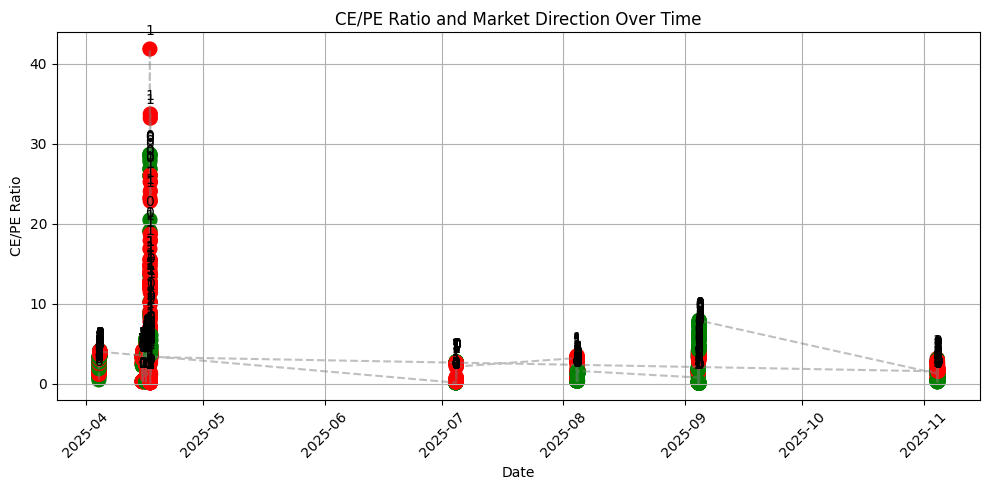

In [15]:
# Map direction to colors
color_map = {0: "green", 1: "red"}
colors = traning_df["direction"].map(color_map)

# Plotting
plt.figure(figsize=(10, 5))
plt.scatter(traning_df["date"], traning_df["ce_pe_oi_ratio"], c=colors, s=100)
plt.plot(traning_df["date"], traning_df["ce_pe_oi_ratio"], linestyle='--', alpha=0.5, color="gray")

# Add direction labels
for i, txt in enumerate(traning_df["direction"]):
    plt.annotate(txt, (traning_df["date"][i], traning_df["ce_pe_oi_ratio"][i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title("CE/PE Ratio and Market Direction Over Time")
plt.xlabel("Date")
plt.ylabel("CE/PE Ratio")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn
print(sklearn.__version__)

1.6.1


In [17]:
features = ['time', 'direction', 'ce_pe_oi_ratio', 'prev_ce_pe_oi_ratio', 
            'ce_beta', 'ce_oi_change', 'pre_ce_oi_change', 
            'pe_beta', 'pe_oi_change', 'pre_pe_oi_change']

target = 'action'  # Buy/Sell/Hold

X_train, X_test, y_train, y_test = train_test_split(traning_df[features], traning_df[target], test_size=0.2, random_state=42)

print(y_train.unique())
# Train XGBoost model
model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Performance report
print(classification_report(y_test, y_pred))

[0 2 6 8 5 1 7]


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6], got [0 1 2 5 6 7 8]

In [ ]:
X_test

In [16]:
y_pred

NameError: name 'y_pred' is not defined

In [12]:
date_str = "16/04/2025  9:15:00"

# Parse the original format
dt = datetime.strptime(date_str.strip(), "%d/%m/%Y %H:%M:%S")

# Convert to desired format
formatted_date = dt.strftime("%Y-%m-%d %H:%M:%S")

print(formatted_date)

2025-04-16 09:15:00


In [18]:
start_time = datetime.now() - timedelta(days = 3)
start_time

datetime.datetime(2025, 4, 17, 17, 44, 32, 460934)

In [12]:
[25000 + i * 100 for i in range(-3, 4)]

[24700, 24800, 24900, 25000, 25100, 25200, 25300]